In [54]:
import pandas as pd
import numpy as np
# 导入数据，查看前几列是否有问题
data = pd.read_csv("./data/2_preprcossing_train.csv", index_col='id')
data.head(5)

,age,info_rate,job_1,job_3,marital_out,education_1,education_2,education_3,default_out,housing_out,...,campaign,pdays,previous,poutcome_out,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.75,0,0,1,0,0,0,0,0,...,NaN,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
1,57.0,1.00,1,0,1,1,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
2,37.0,0.75,1,0,0,1,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
3,40.0,1.00,0,1,1,0,0,0,0,0,...,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0.0
4,56.0,1.00,1,0,1,1,0,0,0,0,...,1.0,999.0,NaN,0,1.1,93.994,-36.4,4.857,5191.0,0.0


In [55]:
# X y 分离
X = data.iloc[:, :-1]
y = data['y']
y

id
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
41183    1.0
41184    0.0
41185    0.0
41186    1.0
41187    0.0
Name: y, Length: 41188, dtype: float64

In [56]:
# 训练测试分离。全局使用唯一的随机种子，避免模型不稳定
from sklearn.model_selection import train_test_split
random_seed = 42
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=random_seed, stratify=y)

In [58]:
# 使用均值填充训练集，并用此均值填充验证集
from sklearn.impute import SimpleImputer
# mean, median, most_frequent, constant(fill_value=), missing_values=-1
impute = SimpleImputer(strategy='mean')
X_train = impute.fit_transform(X_train)
X_valid = impute.transform(X_valid)
X_train = pd.DataFrame(X_train, columns=X.columns)

In [59]:
# 如果正负样本失衡，使用imblearn上采样。
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
oversample = BorderlineSMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_over.value_counts()

0.0    24486
1.0    24486
Name: y, dtype: int64

In [51]:
# 定义绘制超参得分的曲线
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import validation_curve

def plot_validation_curve(train_scores, test_scores, param_range, xscale=None, ylim=[0.5, 1.0]):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='Validation Score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    if xscale is not None:
        plt.xscale(xscale)
    plt.xlabel("Parameter Range")
    plt.ylabel("F1 Measure")
    plt.legend(loc='lower right')
    plt.ylim(ylim)
    plt.show()

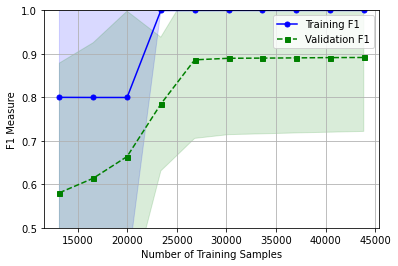

In [53]:
# 先调整学习率
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
# 根据合适的得分，选择 max_depth
rfc = RandomForestClassifier(random_state=random_seed)
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=rfc, X=X_over, y=y_over, scoring='f1',
                   train_sizes=np.linspace(0.3, 1.0, 10), cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='Validation F1')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Measure")
plt.legend(loc='upper right')
plt.ylim([0.5, 1.0])
plt.show()
#25000个样本对随机森林来说，已经足够。

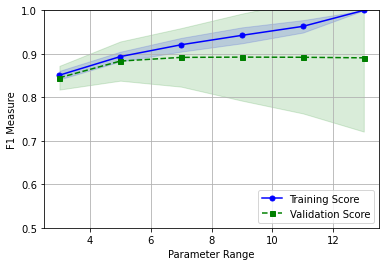

In [60]:
# 一个个调参，减少调参所需时间（虽然不一定能找到最好的超参）。
from sklearn.ensemble import RandomForestClassifier
# 根据合适的得分，选择 max_depth
rfc = RandomForestClassifier(random_state=random_seed)
param_range = [3,5,7,9,11,None]
train_scores, test_scores = validation_curve(estimator=rfc,X=X_over, y=y_over,
                                             param_name='max_depth',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=[3,5,7,9,11,13]) # 注意None

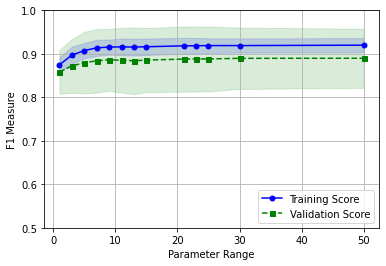

In [62]:
# 调整 n_estimators
param_range = [1, 3, 5, 7, 9, 11, 13, 15, 21, 23, 25, 30, 50]
rfc = RandomForestClassifier(max_depth=7, random_state=random_seed)
train_scores, test_scores = validation_curve(estimator=rfc,X=X_over, y=y_over,
                                             param_name='n_estimators',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range)

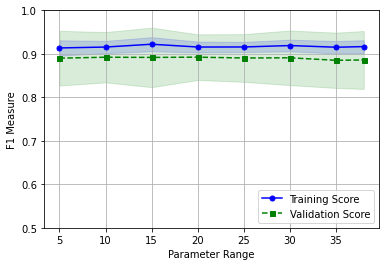

In [63]:
# 调整 max_features
param_range = [int(x * X.shape[1]) for x in np.linspace(start=0.3, stop=0.5, num=6)]
rfc = RandomForestClassifier(max_depth=7, n_estimators=11, random_state=random_seed)
train_scores, test_scores = validation_curve(estimator=rfc,X=X_over, y=y_over,
                                             param_name='max_features',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=param_range)

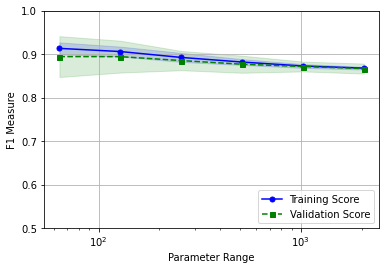

In [64]:
# 调整 min_samples_leaf
param_range = [64, 128, 256, 512, 1024, 2048]
rfc = RandomForestClassifier(max_depth=7, max_features=20, n_estimators=100, random_state=random_seed)
train_scores, test_scores = validation_curve(estimator=rfc,X=X_over, y=y_over,
                                             param_name='min_samples_leaf',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, xscale="log", param_range=[64, 128, 256, 512, 1024, 2048])

In [ ]:
# bootstrap 并调整 max_samples
param_range = [8, 16, 32, 64, 128, 256]
rfc = RandomForestClassifier(bootstrap=True, oob_score=True, min_samples_leaf=1024, max_depth=7, max_features=5, n_estimators=100, random_state=random_seed)
train_scores, test_scores = validation_curve(estimator=rfc,X=X_over, y=y_over,
                                             param_name='max_samples',
                                             param_range=param_range,
                                             scoring='f1',
                                             cv=5)
plot_validation_curve(train_scores=train_scores, test_scores=test_scores, param_range=[8, 16, 32, 64, 128, 256])

In [ ]:
# 最终模型得分
from sklearn.metrics import f1_score
rfc.fit(X_over, y_over)

y_train_pred = rfc.predict(X_over)
y_valid_pred = rfc.predict(X_valid)

print(f1_score(y_over, y_train_pred))
print(f1_score(y_valid, y_valid_pred))